## Prompt and actions on Questions


* Look at `registrants` Table in postgres
* Fetch the region/neignourhood in the query.
* Get all the block groups under the neigbourhood using neigbbourhood-block group mapping file created using overlay layer between them.
* Create bounding box extent with the region as centre of San Diego County.
* Highlight the block groups relevant for our region.
* Classify the block groups according to a score or rank created using combination of variables.

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.features import FeatureLayer, FeatureLayerCollection, GeoAccessor
from arcgis.geocoding import geocode
from arcgis.geometry import buffer, Point
from arcgis.geometry.filters import intersects

import pandas as pd

import sys
sys.path.append('../../')
from utils import get_config

In [2]:
username = get_config("arcgis","username")
password = get_config("arcgis","passkey")
gis = GIS("https://ucsdonline.maps.arcgis.com/home", username=username, password=password)

### Check if the user belongs to a Food desert

#### Check meal_gap or CalFresh data to check Food insecurity rate for some radius of area
* Map the meal gap data is at County level, not sure if it is really helpful for us.
* CalFresh Data might need to be standardized, but it is on zip level.

#### Picking some random variable from demographics for Map rending POC
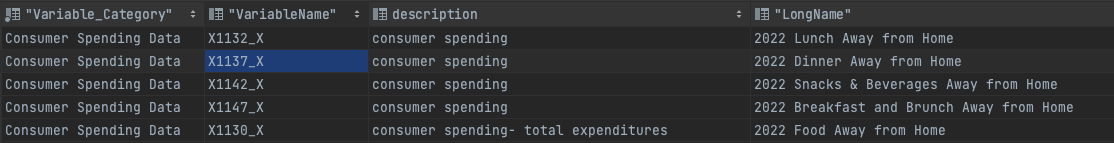

In [3]:
# Query the block group for respective variables and feature layer.
#variables = "demographics"
variables = "average_consumer_spending"
if variables=="demographics":
    url = "https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/aff1b6/FeatureServer/0"
elif variables == "average_consumer_spending":
    url = "https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/a2afc4/FeatureServer/0"
ft_lyr = FeatureLayer(gis=gis,
                       url=url)

# Picking up sample variables for just poc on rendering maps as per our need.
out_fields = ["fips", "X1130_A", "X1132_A", "X1137_A", "X1147_A", "X1142_A"]  

##### Can we query a geography within a certain radius of a location.

#### Picking home address from registrant table

In [4]:
registrant_address = "11010 Caminito Alvarez, San Diego, 92126"
matched_registrant_address = geocode(address=registrant_address,
                 max_locations = 1
                )
# matched_registrant_address

Listing the address matched...

In [5]:
lat_long = [matched_registrant_address[0]['location']['y'],matched_registrant_address[0]['location']['x']]
address_score = matched_registrant_address[0]['score']
address_identified = matched_registrant_address[0]['address']
print(f"Important Fields: \n Address Matched: {address_identified} \n Latitude,Longitude: {lat_long}\n Match SCore: {address_score}")

Important Fields: 
 Address Matched: 11010 Caminito Alvarez, San Diego, California, 92126 
 Latitude,Longitude: [32.90706625343636, -117.1675950182451]
 Match SCore: 100


#### Creating a Point Geometry and create a 2.0 Mile radius to create a buffer

In [6]:
point_location = matched_registrant_address[0]['location']
print(f"point_location: {point_location}")
point_geom = Point({"x": point_location['x'], "y": point_location['y'], "spatialReference" : {'wkid': 4326, 'latestWkid': 4326}})

## This buffer query was failing because ESRI takes constant values instead of names for unit.
# So here 9035 is Value for constant esriSRUnit_SurveyMile which is described as 'US Survey Mile'
# Link for more constants: http://resources.arcgis.com/en/help/arcobjects-cpp/componenthelp/index.html#/esriSRUnitType_Constants/000w00000042000000/
buffer_geom = buffer(geometries=[point_geom], distances=1.0, unit='9035', in_sr={'wkid': 4326, 'latestWkid': 4326})


point_location: {'x': -117.1675950182451, 'y': 32.90706625343636}


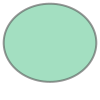

In [7]:
target_geometry = buffer_geom[0]
target_geometry

Creating spatial intersect filter for the radius buffer

In [8]:

buffer_filter = intersects(target_geometry,{'wkid': 4326, 'latestWkid': 4326})


In [9]:
buffer_filter['inSR']

{'wkid': 4326, 'latestWkid': 4326}

Querying the respective variable feature layer with this spatial filter.

In [10]:
result_rows = ft_lyr.query(out_fields=out_fields,
                            return_geometry=True,
                            geometry_filter=buffer_filter,
                            as_df=True)
print(f"Number of block groups identified: {result_rows.shape[0]}")
result_rows.head(3)

Number of block groups identified: 15


,FID,fips,x1130_a,x1132_a,x1137_a,x1147_a,x1142_a,SHAPE
0,507,060730083462,9530.2,2771.22,4570.95,922.03,783.18,"{""rings"": [[[-13043684.4378, 3883791.263], [-1..."
1,526,060730083481,5568.62,1566.78,2686.11,550.28,465.38,"{""rings"": [[[-13041588.8481, 3884982.09870001]..."
2,529,060730083482,5764.1,1609.44,2841.88,563.77,449.92,"{""rings"": [[[-13041527.1770999, 3884297.419799..."


#### Creating a bounding box

In [29]:
map_centre = [point_location['y'],point_location['x']]
print(f"Map Centre: {map_centre}")
m1 = gis.map(map_centre, zoomlevel=12)

# Drawing a radius boundary for ease of demo.
m1.draw(target_geometry)
m1

Map Centre: [32.90706625343636, -117.1675950182451]


MapView(layout=Layout(height='400px', width='100%'))

#### Identify the relevant block groups

In [28]:
m2 = gis.map(map_centre, zoomlevel=12)
result_rows.spatial.plot(renderer_type='c',                          
                         map_widget= m2,)
# Drawing a radius boundary for ease of demo.
m2.draw(target_geometry)
m2

MapView(layout=Layout(height='400px', width='100%'))

#### Classify the Block Groups

In [16]:
m3 = gis.map(map_centre, zoomlevel=12)
result_rows.spatial.plot(renderer_type='c',
                         method='esriClassifyNaturalBreaks',
                         class_count=10,  # choose the number of classes
                         col='x1130_a',
                         cmap='hot',  # color map to pick colors from for each class
                         alpha=0.2 ,
                         map_widget= m3,)
m3

MapView(layout=Layout(height='400px', width='100%'))

#### Check Food Swamp: Density of fast food and Convenience Store

#### Do these geometries have Highly Palatable Food ?

#### e.g. Mexican Food business in the our buffer area and business type as Food Truck. (Business type data to be picked up from where? )

In [33]:
biz_layer = FeatureLayer(url="https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/a52c7d/FeatureServer/0")


In [34]:
biz_cat = 'mexican'
selected_biz = biz_layer.query(geometry_filter=buffer_filter,
               as_df=True,
               return_geometry=True,
               where=f"business_t like '%{biz_cat}%'")
selected_biz

,FID,business_n,zip,business_t,city,SHAPE
0,6508,Taco Thunder,92121,Burrito restaurant;Mexican restaurant;Taco res...,San Diego,"{""x"": -13043797.547633605, ""y"": 3882911.198792..."
1,34060,Habaneros Mexican Grill,92121,Mexican restaurant;Latin American restaurant;R...,San Diego,"{""x"": -13043486.710219463, ""y"": 3882937.492026..."
2,43703,Kotija Jr Taco Shop Mira Mesa,92121,Mexican restaurant,San Diego,"{""x"": -13043798.08196716, ""y"": 3882927.2558234..."


In [35]:
m4 = gis.map(map_centre, zoomlevel=13)
selected_biz.spatial.plot(renderer_type='c',                          
                         map_widget= m4,)
m4.draw(target_geometry)
m4

MapView(layout=Layout(height='400px', width='100%'))